In [49]:
import os
import csv
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn import linear_model, metrics
import scipy.stats as st
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [50]:
# Changing Directory
os.chdir("A:\\WebEconomics\\dataset")


In [51]:
# Reading Data
df = pd.read_csv('validation.csv')
df_train = pd.read_csv('train.csv')

## Selecting Wanted Features

In [52]:
# Define our features
features = ["click", "weekday", "hour", "region", "slotwidth", 'slotheight', 'bidprice', 'payprice']
df = df[features]
df = df.dropna()

df_train = df_train[features]
df_train = df_train.dropna()

In [53]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

df_train['slotsize'] = df_train['slotwidth'] * df_train['slotheight'] 
df_train.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [54]:
df.head()

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,5,14,216,227,102,75000
1,0,3,14,216,277,118,16000
2,0,1,13,146,241,77,90000
3,0,5,18,146,241,77,90000
4,0,5,14,275,300,178,94080


## Labeling and Categorising Data

Categorising:
- Hour: 
    - 0:00~07:59 : 1
    - 08:00~15:59: 2
    - 16:00~23:59: 3
- Size:
    - 0~40000     : 1
    - 40000~80000 : 2
    - 80000~120000: 3

In [55]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])

df_train['hour'] = pd.cut(df_train['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df_train['slotsize'] = pd.cut(df_train['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])

df.head()  

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,5,2,216,227,102,2
1,0,3,2,216,277,118,1
2,0,1,2,146,241,77,3
3,0,5,3,146,241,77,3
4,0,5,2,275,300,178,3


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299749 entries, 0 to 299748
Data columns (total 7 columns):
click       299749 non-null int64
weekday     299749 non-null int64
hour        299749 non-null category
region      299749 non-null int64
bidprice    299749 non-null int64
payprice    299749 non-null int64
slotsize    299745 non-null category
dtypes: category(2), int64(5)
memory usage: 14.3 MB


In [57]:
df = df.dropna()
print(df.isnull().any().any())

df_train = df_train.dropna()
print(df_train.isnull().any().any())


False
False


### Dummy Coding

Since all of the variables are categorical integers, we need to convert these numbers into categorical type. To do this, we can use dummy coding. 

We will use [**``sklearn.preprocessing.LabelEncoder()``**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)


Encode labels with value between 0 and n_classes-1.

In [58]:
from sklearn import preprocessing

# Set the random seed
np.random.seed(12)

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

In [59]:
# Convert all the features to numeric values
df["click"] = label_encoder.fit_transform(df["click"])
df["weekday"] = label_encoder.fit_transform(df["weekday"])
df["region"] = label_encoder.fit_transform(df["region"])

df["hour"] = label_encoder.fit_transform(df["hour"])
df["slotsize"] = label_encoder.fit_transform(df["slotsize"])

In [60]:
# Convert all the features to numeric values
df_train["click"] = label_encoder.fit_transform(df_train["click"])
df_train["weekday"] = label_encoder.fit_transform(df_train["weekday"])
df_train["region"] = label_encoder.fit_transform(df_train["region"])

df_train["hour"] = label_encoder.fit_transform(df_train["hour"])
df_train["slotsize"] = label_encoder.fit_transform(df_train["slotsize"])

## Training Logistic Regression (linear_model.LogisticRegression)

In [61]:
# Defining X and Y
X = df_train[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df_train['click']

In [62]:
# Training the model
logreg = linear_model.LogisticRegression()

In [63]:
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
logreg.score(X, Y)

0.99924600929847729

In [65]:
logreg.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [66]:
narray = logreg.predict(X)
print(narray.sum())

0


In [67]:
logreg.predict_proba(X)

array([[  9.98916139e-01,   1.08386086e-03],
       [  9.99062280e-01,   9.37719823e-04],
       [  9.99413771e-01,   5.86228951e-04],
       ..., 
       [  9.99333946e-01,   6.66054185e-04],
       [  9.99328335e-01,   6.71665270e-04],
       [  9.99314741e-01,   6.85259382e-04]])

In [68]:
probarray = logreg.predict_proba(df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]])
df['log_prob'] =probarray[:,1]

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


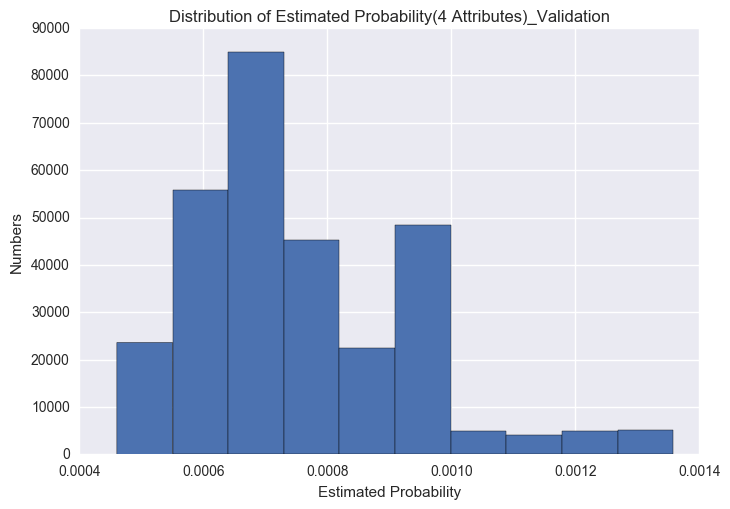

In [69]:
plt.xlabel('Estimated Probability')
plt.ylabel('Numbers')
df['log_prob'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Probability(4 Attributes)_Validation")
plt.legend()
plt.show()


In [70]:
print(df['log_prob'].describe())

count    299745.000000
mean          0.000756
std           0.000176
min           0.000460
25%           0.000613
50%           0.000705
75%           0.000899
max           0.001358
Name: log_prob, dtype: float64


In [71]:
f = interpolate.interp1d( [min(df['log_prob']) , max(df['log_prob'])], [min(df['payprice']), max(df['payprice']) ])
df['estimatedBidPrice'] = df['log_prob'].apply(  lambda x: f(x) )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


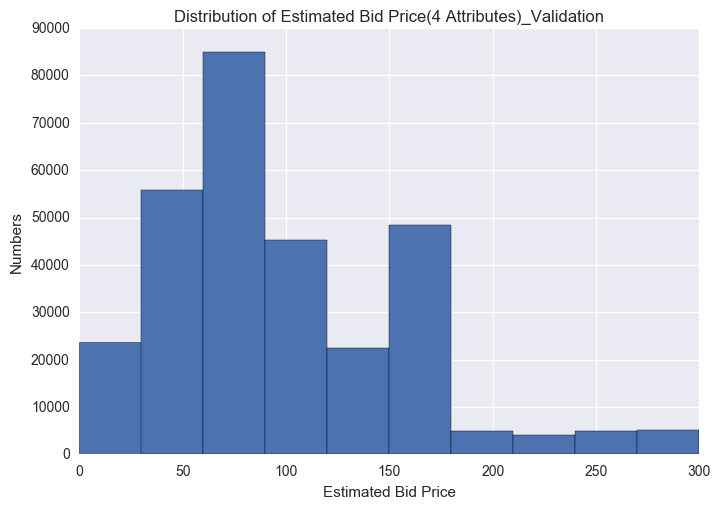

In [72]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_Validation")
plt.legend()
plt.show()


In [73]:
# Information about pay price
print(df['estimatedBidPrice'].describe())
print("variance:", df['estimatedBidPrice'].var())
print("skewness:", st.skew(df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean         98.741630
std          58.788018
min           0.000000
25%          51.099849
50%          81.871508
75%         146.553723
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 3456.03109799733
skewness: 0.8583693570529617
kurtosis: 0.6726221070664136


In [74]:
# Information about pay price
print(df['payprice'].describe())
print("variance:", df['payprice'].var())
print("skewness:", st.skew(df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


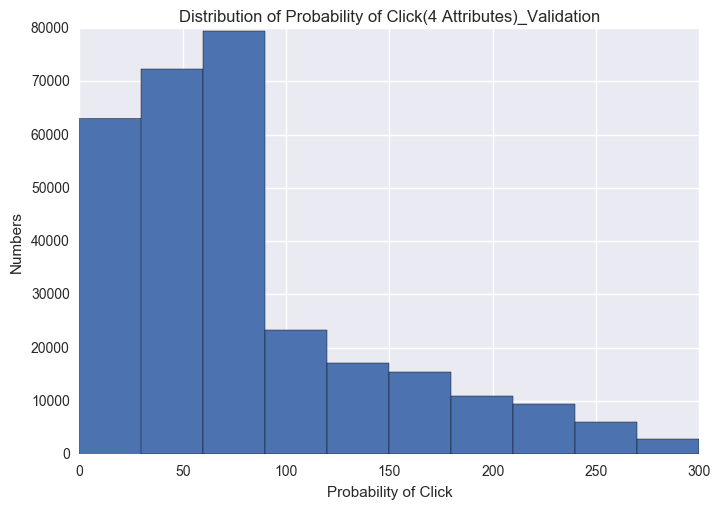

In [75]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(4 Attributes)_Validation")
plt.legend()
plt.show()


In [76]:
f = interpolate.interp1d( [min(df['log_prob']) , max(df['log_prob'])], [min(df['payprice']), max(df['payprice']) ])
df['estimatedBidPrice_x2.5'] = df['log_prob'].apply(  lambda x: f(x)*2.5 )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


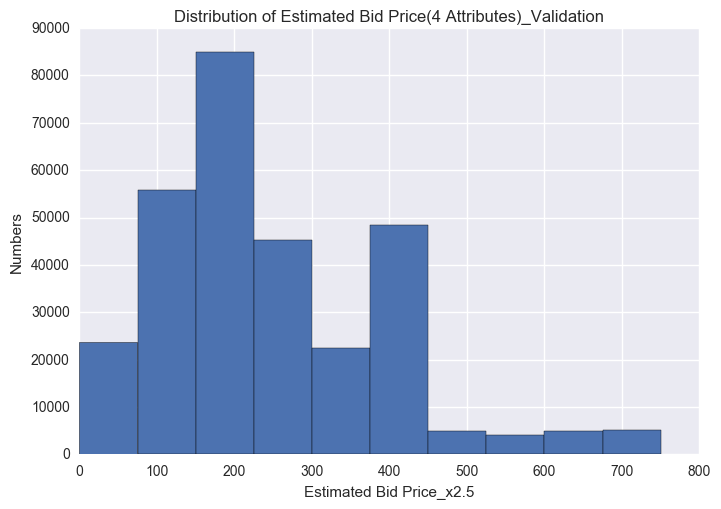

In [77]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_Validation")
plt.legend()
plt.show()


## LR

#### Original

In [78]:
impression = df[df['estimatedBidPrice'] > df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = df[df['estimatedBidPrice_x2.5'] > df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

In [79]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])


print(x)

+----------------------+----------+-----+---------------------+
|       Variable       |Impression|Click|         CTR         |
+----------------------+----------+-----+---------------------+
|  estimatedBidPrice   |  174899  | 108 |0.0006174992424199109|
|estimatedBidPrice_x2.5|  266258  | 199 |0.0007473953834250989|
+----------------------+----------+-----+---------------------+


In [ ]:
impression = df[df['estimatedBidPrice'] > df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = df[df['estimatedBidPrice_x2.5'] > df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

In [80]:
## Deleting 25% from df['estimatedBidPrice_x2.5']
impression_d25 = df[(df['estimatedBidPrice_x2.5'] > df['payprice']) & (df['log_prob'] > df['log_prob'].quantile(0.25) )]
click_d25 = impression_d25[impression_d25['click'] == 1 ]

In [82]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

print(x)

+--------------------------+----------+-----+---------------------+
|         Variable         |Impression|Click|         CTR         |
+--------------------------+----------+-----+---------------------+
|    estimatedBidPrice     |  174899  | 108 |0.0006174992424199109|
|  estimatedBidPrice_x2.5  |  266258  | 199 |0.0007473953834250989|
|estimatedBidPrice_x2.5_d25|  217493  | 178 |0.0008184171444598217|
+--------------------------+----------+-----+---------------------+


In [83]:
## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d50 = df[(df['estimatedBidPrice_x2.5'] > df['payprice']) & (df['log_prob'] > df['log_prob'].quantile(0.50) )]
click_d50 = impression_d50[impression_d50['click'] == 1 ]

In [84]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

print(x)

+--------------------------+----------+-----+---------------------+
|         Variable         |Impression|Click|         CTR         |
+--------------------------+----------+-----+---------------------+
|    estimatedBidPrice     |  174899  | 108 |0.0006174992424199109|
|  estimatedBidPrice_x2.5  |  266258  | 199 |0.0007473953834250989|
|estimatedBidPrice_x2.5_d25|  217493  | 178 |0.0008184171444598217|
|estimatedBidPrice_x2.5_d50|  148739  | 133 |0.0008941837715730239|
+--------------------------+----------+-----+---------------------+


In [85]:
## Deleting 50% from df['estimatedBidPrice_x2.5']
impression_d75 = df[(df['estimatedBidPrice_x2.5'] > df['payprice']) & (df['log_prob'] > df['log_prob'].quantile(0.75) )]
click_d75 = impression_d75[impression_d75['click'] == 1 ]

In [86]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

print(x)

+--------------------------+----------+-----+---------------------+
|         Variable         |Impression|Click|         CTR         |
+--------------------------+----------+-----+---------------------+
|    estimatedBidPrice     |  174899  | 108 |0.0006174992424199109|
|  estimatedBidPrice_x2.5  |  266258  | 199 |0.0007473953834250989|
|estimatedBidPrice_x2.5_d25|  217493  | 178 |0.0008184171444598217|
|estimatedBidPrice_x2.5_d50|  148739  | 133 |0.0008941837715730239|
|estimatedBidPrice_x2.5_d75|  74900   |  75 |0.0010013351134846463|
+--------------------------+----------+-----+---------------------+


In [87]:
## Deleting 62.5% from df['estimatedBidPrice_x2.5']
impression_d625 = df[(df['estimatedBidPrice_x2.5'] > df['payprice']) & (df['log_prob'] > df['log_prob'].quantile(0.625) )]
click_d625 = impression_d625[impression_d625['click'] == 1 ]

In [88]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d25", impression_d25.shape[0], \
           click_d25.shape[0], \
           click_d25.shape[0]/impression_d25.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d50", impression_d50.shape[0], \
           click_d50.shape[0], \
           click_d50.shape[0]/impression_d50.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d75", impression_d75.shape[0], \
           click_d75.shape[0], \
           click_d75.shape[0]/impression_d75.shape[0]])

x.add_row(["estimatedBidPrice_x2.5_d62.5", impression_d625.shape[0], \
           click_d625.shape[0], \
           click_d625.shape[0]/impression_d625.shape[0]])


print(x)

+----------------------------+----------+-----+---------------------+
|          Variable          |Impression|Click|         CTR         |
+----------------------------+----------+-----+---------------------+
|     estimatedBidPrice      |  174899  | 108 |0.0006174992424199109|
|   estimatedBidPrice_x2.5   |  266258  | 199 |0.0007473953834250989|
| estimatedBidPrice_x2.5_d25 |  217493  | 178 |0.0008184171444598217|
| estimatedBidPrice_x2.5_d50 |  148739  | 133 |0.0008941837715730239|
| estimatedBidPrice_x2.5_d75 |  74900   |  75 |0.0010013351134846463|
|estimatedBidPrice_x2.5_d62.5|  111968  | 106 |0.0009466990568733923|
+----------------------------+----------+-----+---------------------+


In [89]:
df[df['log_prob'] == 0].shape[0]

0